# Simulating and Identifying a Quadratic Boost Converter using PLECS and Python

This document walks through the process of simulating a quadratic boost converter in PLECS, retrieving the simulation data, performing system identification using a data-driven approach (DMDP - Data-Driven Model Predictive control), and finally, analyzing the relationship between a circuit parameter (R) and the identified model coefficients using polynomial regression.


### 1. Prerequisites and Imports

First, we need to import the necessary Python libraries.

- xmlrpc.client is used to communicate with the PLECS simulation software.

- matplotlib.pyplot is for plotting graphs.

- numpy is for numerical operations, especially array manipulation.

- cvxpy is a modeling language for convex optimization problems.

- sklearn.preprocessing and sklearn.linear_model are used for polynomial regression.


In [4]:
import xmlrpc.client as xml
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

### 2. PLECS Connection and Simulation Setup

We establish a connection to the PLECS XML-RPC server and define the model name.


In [5]:
# Establish connection with PLECS
plecs = xml.Server("http://localhost:9998/RPC2").plecs

# Define the PLECS model name
model = 'quadratic_boost_converter_dmdp_identification'
# file_type = '.plecs' # File type, if needed for other operations

**Note**: Ensure PLECS is running and the XML-RPC server is enabled at the specified address and port.


### 3. Data Acquisition from PLECS

Simulate the PLECS model and retrieve the time, input, and output data.


In [6]:
# Simulate the model and get raw data
simulation_results = plecs.simulate(model)
time_raw = np.array(simulation_results['Time'])
input_raw = np.array(simulation_results['Values'][0]) # Assuming first output is input current/signal
output_raw = np.array(simulation_results['Values'][1]) # Assuming second output is output voltage

### 4. Data Preprocessing: Downsampling

The raw simulation data might be too dense. We define a function to downsample the data by averaging, which can help in reducing computation time for subsequent analysis and smoothing out noise.


In [7]:
def downsample_average(arr, factor):
    """
    Downsamples an array by averaging consecutive elements.
    Args:
        arr (np.array): The input array.
        factor (int): The downsampling factor.
    Returns:
        np.array: The downsampled array.
    """
    # Ensure the array length is a multiple of the factor
    end_index = len(arr) - (len(arr) % factor)
    return arr[:end_index].reshape(-1, factor).mean(axis=1)

# Downsample the data
downsample_factor = 1000
output_resampled = downsample_average(output_raw, factor=downsample_factor)
input_resampled = downsample_average(input_raw, factor=downsample_factor)
time_resampled = downsample_average(time_raw, factor=downsample_factor)

### 5. Initial Data Visualization

Let's plot the downsampled input and output signals to get a visual understanding of the system's behavior.


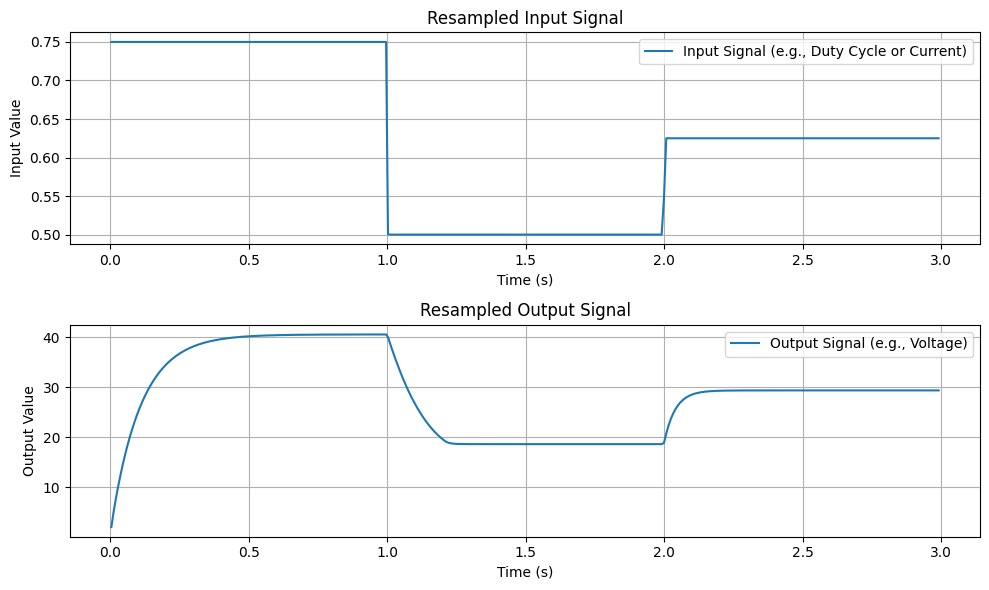

In [8]:
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.plot(time_resampled, input_resampled, label='Input Signal (e.g., Duty Cycle or Current)')
plt.title('Resampled Input Signal')
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time_resampled, output_resampled, label='Output Signal (e.g., Voltage)')
plt.title('Resampled Output Signal')
plt.xlabel('Time (s)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 6. System Identification: Data-Driven Model Predictive Control (DMDP) Approach

We aim to identify a model of the form:

$$ Y\_{k+1} = A \cdot Z_k + B \cdot W_k $$

where $Y_k$ is the output, $W_k$ is the input, and $Z_k$ is a state vector potentially including non-linear terms of the output (e.g., $Y_k$, $Y_k^2$, $Y_k^3$)

We use `cvxpy` to solve the optimization problem for finding matrices A and B that minimize the prediction error.


In [9]:
# Prepare data for system identification
Y_ = output_resampled
U_ = input_resampled

# Z contains current output and its powers (up to 3rd order)
# W contains current input
# YY contains the next state of the output
Z_matrix = np.array([Y_[:-1], Y_[:-1]**2, Y_[:-1]**3])
W_matrix = np.array([U_[:-1]])
YY_vector = np.array([Y_[1:]])

# Define CVXPY variables for the matrices A and B
A_param = cp.Variable((1, 3)) # 1 output, 3 terms in Z
B_param = cp.Variable((1, 1)) # 1 output, 1 term in W

# Define the cost function (minimize norm of error)
cost_function = cp.norm2(YY_vector - (A_param @ Z_matrix + B_param @ W_matrix))
objective = cp.Minimize(cost_function)

# Define and solve the problem
problem = cp.Problem(objective)
problem.solve(solver=cp.CLARABEL) # Using CLARABEL solver

# Extracted parameters
A_identified = A_param.value
B_identified = B_param.value

print("Identified A matrix:", A_identified)
print("Identified B matrix:", B_identified)

Identified A matrix: [[ 7.63185784e-01  6.30779541e-03 -7.24342557e-05]]
Identified B matrix: [[5.4279556]]


### 7. Simulating the Identified DMDP Model

Now, we use the identified matrices `A_identified` and `B_identified` to simulate the system's response to a predefined input sequence. This helps validate the identified model.


In [10]:
# Initial conditions for the DMDP model simulation
y_dmdp_current = 0  # Initial output
u_dmdp_current = 0.75 # Initial input

# Arrays to store the simulated DMDP model output and input
Y_dmdp_simulated = np.array([])
U_dmdp_sequence = np.array([])

# Simulate step-by-step using the identified model
for t_step in time_resampled:
    # Prepare W_d (input vector for DMDP model)
    W_d_step = np.array([u_dmdp_current])
    # Prepare Z_d (state vector for DMDP model)
    Z_d_step = np.array([y_dmdp_current, y_dmdp_current**2, y_dmdp_current**3])

    # Predict next output using the identified model
    y_dmdp_next = A_identified @ Z_d_step + B_identified @ W_d_step
    y_dmdp_current = y_dmdp_next[0] # Update current output

    # Store results
    Y_dmdp_simulated = np.append(Y_dmdp_simulated, y_dmdp_current)
    U_dmdp_sequence = np.append(U_dmdp_sequence, u_dmdp_current)

    # Change input u_dmdp_current at specific time points for testing
    if t_step >= 1.0 and t_step < 2.0: # Time check should be robust
        u_dmdp_current = 0.5
    elif t_step >= 2.0:
        u_dmdp_current = 0.625


**Note**: The length of `Y_dmdp_simulated` and `U_dmdp_sequence` will match `time_resampled`.


### 8. Visualizing DMDP Model Performance

Compare the output of the identified DMDP model with the actual resampled output from PLECS. Also, plot the error between them.


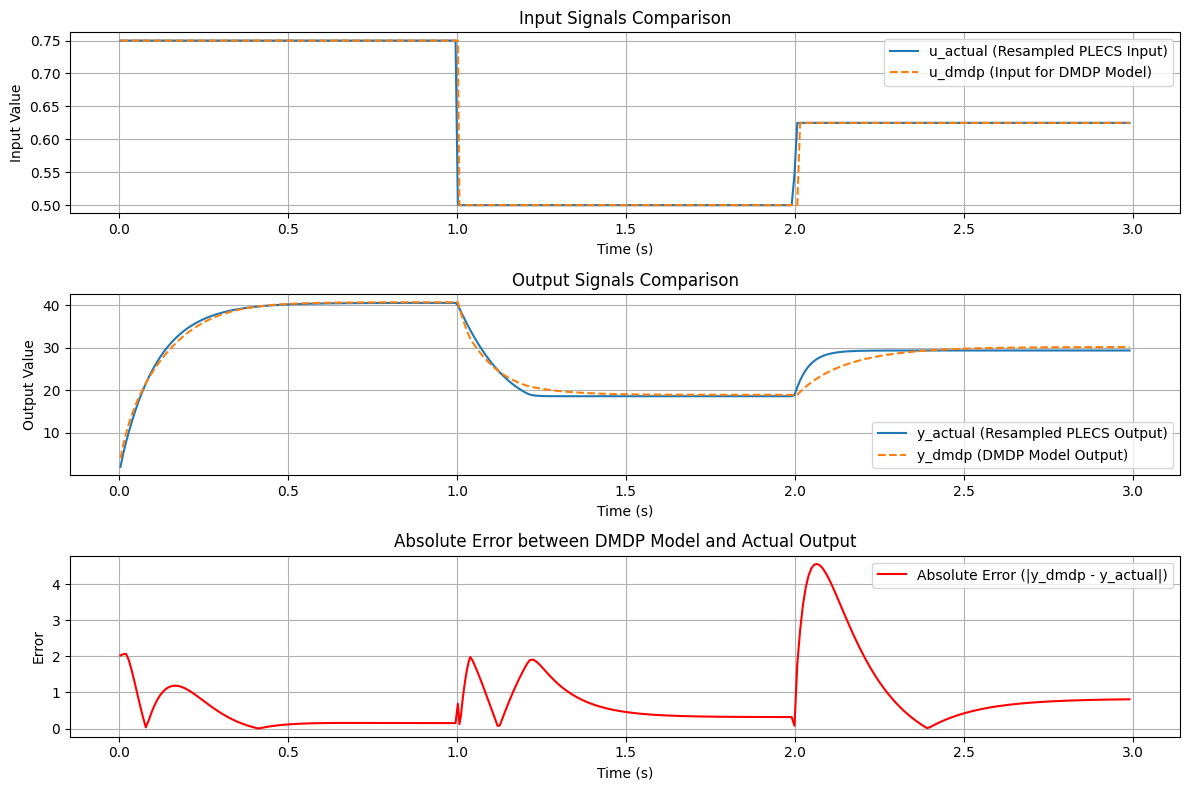

In [11]:
plt.figure(figsize=(12, 8))

# Plot Input Signals
plt.subplot(3,1,1)
plt.plot(time_resampled, input_resampled, label='u_actual (Resampled PLECS Input)')
plt.plot(time_resampled, U_dmdp_sequence, label='u_dmdp (Input for DMDP Model)', linestyle='--')
plt.title('Input Signals Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
plt.legend()
plt.grid(True)

# Plot Output Signals
plt.subplot(3,1,2)
plt.plot(time_resampled, output_resampled, label='y_actual (Resampled PLECS Output)')
plt.plot(time_resampled, Y_dmdp_simulated, label='y_dmdp (DMDP Model Output)', linestyle='--')
plt.title('Output Signals Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Output Value')
plt.legend()
plt.grid(True)

# Plot Error
plt.subplot(3,1,3)
# Ensure lengths match for error calculation if Y_dmdp_simulated has different length
min_len = min(len(Y_dmdp_simulated), len(output_resampled))
error = np.abs(Y_dmdp_simulated[:min_len] - output_resampled[:min_len])
plt.plot(time_resampled[:min_len], error, label='Absolute Error (|y_dmdp - y_actual|)', color='red')
plt.title('Absolute Error between DMDP Model and Actual Output')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 9. Polynomial Regression for Model Coefficients vs. Parameter R

This section explores how the coefficients of a simplified model (e.g., $Y_{k+1} = a_0 u_k + a_1 y_k + a_2 y_k^2 + a_3 y_k^3$ ) change with variations in a system parameter, denoted here as `R` (e.g., load resistance). We assume that for different values of `R`, the coefficients $a_0$, $a_1$, $a_2$, $a_3$ have been previously determined (these are the `_vals` arrays). We will fit a polynomial to describe this relationship.

Note: The coefficients `a0_vals, a1_vals, a2_vals, a3_vals` are assumed to be derived from a process similar to the DMDP identification performed earlier, but for different values of `R`. The matrix `A_identified` from the previous DMDP step would correspond to [$a_1$, $a_2$, $a_3$] and `B_identified` to [$a_0$] for a specific `R`.



a0 (coeff of u)(R) = 3.35936209 + +7.47356661e-03 * R - 6.69063805e-06 * R^2


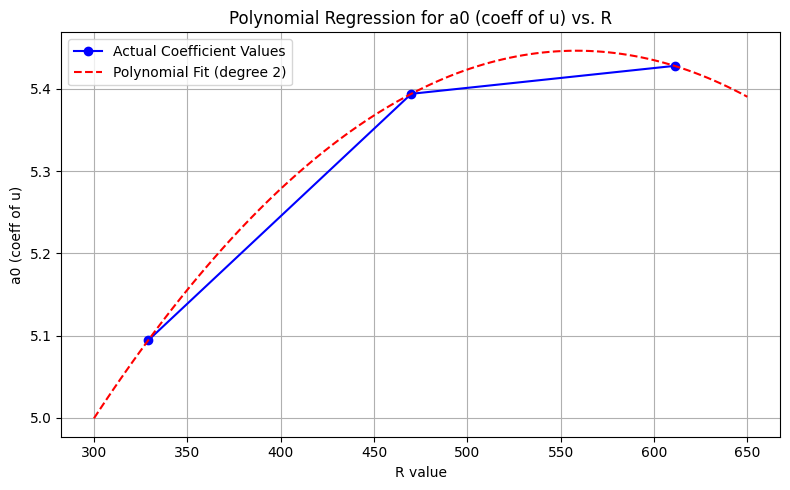


a1 (coeff of y)(R) = 0.03236945 + +2.56386196e-03 * R - 2.23856501e-06 * R^2


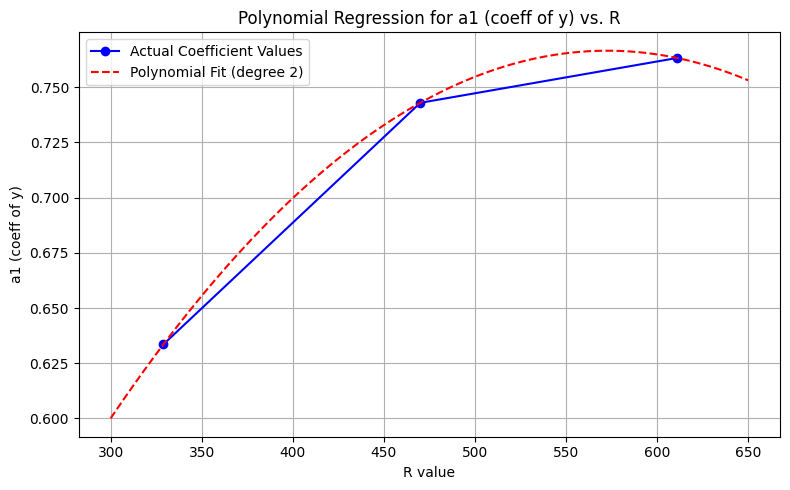


a2 (coeff of y^2)(R) = 0.08533793 - 2.80608046e-04 * R + +2.47565463e-07 * R^2


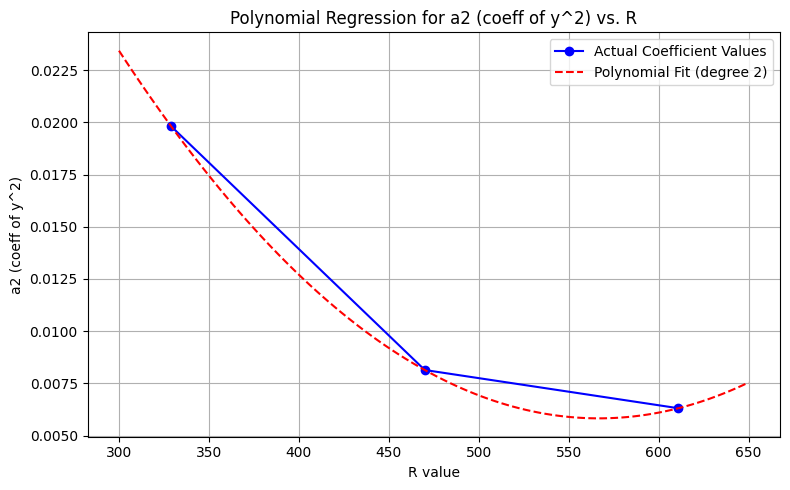


a3 (coeff of y^3)(R) = -0.00206116 + +7.08037383e-06 * R - 6.26104106e-09 * R^2


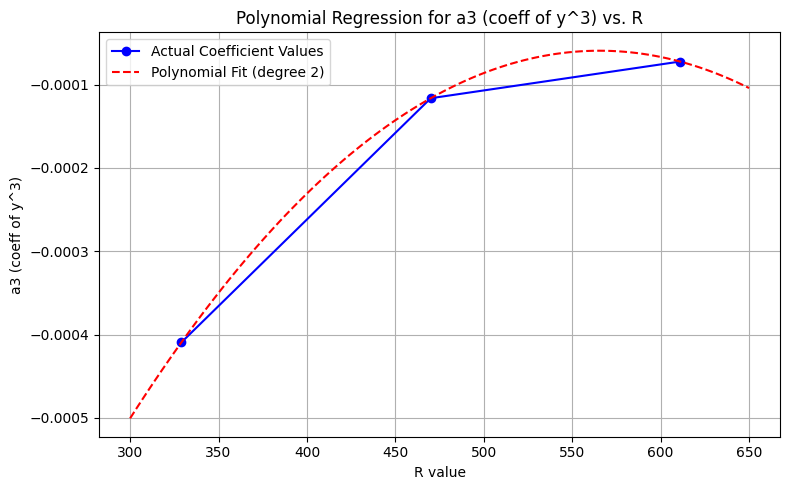

In [12]:
# Data for polynomial regression
# R_vals: Different values of a parameter (e.g., resistance)
R_values = np.array([329, 470, 611]).reshape(-1, 1)

# Corresponding coefficient values (example data)
# These would typically be obtained by running the system identification (like section 6)
# for each value of R.
# B_param corresponds to a0 (coefficient of u)
# A_param corresponds to a1, a2, a3 (coefficients of y, y^2, y^3)
a0_coefficient_values = np.array([5.09396415, 5.39397645, 5.42795560]) # Coeff for u
a1_coefficient_values = np.array([0.633575524, 0.742885565, 0.763185784]) # Coeff for y
a2_coefficient_values = np.array([0.0198146114, 0.00813935444, 0.00630779541]) # Coeff for y^2
a3_coefficient_values = np.array([-0.000409422911, -0.000116452826, -0.0000724342557]) # Coeff for y^3

coefficient_names = ["a0 (coeff of u)", "a1 (coeff of y)", "a2 (coeff of y^2)", "a3 (coeff of y^3)"]
all_coefficient_values = [a0_coefficient_values, a1_coefficient_values, a2_coefficient_values, a3_coefficient_values]

# Interval for interpolation and plotting
R_interpolation_range = np.linspace(300, 650, 100).reshape(-1, 1)

# Degree of the polynomial for fitting
polynomial_degree = 2

def fit_plot_and_print_polynomial_equation(R_data, coeff_data, coeff_name, degree=2):
    """
    Fits a polynomial to the R vs. coefficient data, plots it, and prints the equation.
    Args:
        R_data (np.array): Array of R values.
        coeff_data (np.array): Array of corresponding coefficient values.
        coeff_name (str): Name of the coefficient for labeling.
        degree (int): Degree of the polynomial to fit.
    """
    poly_features = PolynomialFeatures(degree=degree)
    R_poly_features = poly_features.fit_transform(R_data)

    model = LinearRegression()
    model.fit(R_poly_features, coeff_data)

    # Print the equation
    intercept = model.intercept_
    coefficients = model.coef_
    
    terms = [f"{intercept:.8f}"]
    for i in range(1, len(coefficients)): # coefficients[0] is for the intercept, which is already handled
        if coefficients[i] != 0 : # Only include non-zero terms
             terms.append(f"{coefficients[i]:+.8e} * R^{i}")
    
    # Handle the case where degree is 0 (intercept only) or if all higher order coeffs are 0
    if len(terms) == 1 and intercept == coefficients[0] and degree > 0: 
        # This means only R^0 term was significant or degree was 0.
        # For degree > 0, model.coef_ includes the coefficient for R^0 as coef_[0] if include_bias=False for PolyFeatures,
        # but LinearRegression's intercept_ handles the bias. So coef_[0] from LinearRegression is for R^1.
        # The loop for terms starts from R^1.
        # If LinearRegression model.coef_ is [c1, c2 ...], intercept is c0.
        # PolynomialFeatures transforms R into [1, R, R^2, ...].
        # So model.coef_[0] is the coeff for R^1 (if using poly_features.transform's output)
        # Let's adjust the term generation based on degree.
        # The intercept is the constant term. model.coef_[0] is for R, model.coef_[1] for R^2 etc.
        pass # Intercept is already included.

    # Revised equation printing
    eq_terms = [f"{model.intercept_:.8f}"] # Intercept (R^0 term)
    if degree >= 1:
      eq_terms.append(f"{model.coef_[1]:+.8e} * R") # R^1 term
    if degree >= 2:
      eq_terms.append(f"{model.coef_[2]:+.8e} * R^2") # R^2 term
    # Extend if higher degrees are used
    
    equation = f"{coeff_name}(R) = {' + '.join(eq_terms).replace(' + -', ' - ')}"
    print(f"\n{equation}")

    # Prediction for plotting
    R_interp_poly_features = poly_features.transform(R_interpolation_range)
    coeff_predicted = model.predict(R_interp_poly_features)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(R_data, coeff_data, 'bo-', label="Actual Coefficient Values")
    plt.plot(R_interpolation_range, coeff_predicted, 'r--', label=f"Polynomial Fit (degree {degree})")
    plt.title(f"Polynomial Regression for {coeff_name} vs. R")
    plt.xlabel("R value")
    plt.ylabel(coeff_name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Apply the function for all coefficients
for name, values in zip(coefficient_names, all_coefficient_values):
    fit_plot_and_print_polynomial_equation(R_values, values, name, degree=polynomial_degree)

### 10. Conclusion

This notebook demonstrated a workflow for:

1. Simulating a power electronics converter in PLECS.

2. Extracting and preprocessing simulation data.

3. Identifying a nonlinear dynamic model using `cvxpy` for a DMDP-like structure.

4. Validating the identified model by comparing its simulated output against actual data.

5. Analyzing how model parameters change with a circuit variable (`R`) using polynomial regression.

This approach can be valuable for understanding system dynamics, controller design, and parameter sensitivity analysis.
